#Importing Required Packages

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=9454c3ebbbfa8a16fd8a6abb6c7bb28aca3956b77a801cfc55cfc854ffd02fc0
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
import pandas_ta
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime as dt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pandas as pd
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]


In [ ]:
sp500

,Symbol,Company,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [ ]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-') #because "." is not supported in yfinance

In [ ]:
print(sp500['Symbol'])

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     XYL
499     YUM
500    ZBRA
501     ZBH
502     ZTS
Name: Symbol, Length: 503, dtype: object


In [ ]:
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(sp500['Symbol'].tolist(), start=start_date, end=end_date).stack()

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['AMTM', 'SOLV', 'SW', 'GEV', 'VLTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


In [ ]:
df.index.names = ['date','ticker']
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375286   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718922   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145813   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.254013   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[982460 rows x 6 columns]

# Calculate features and technical indicators for each stock



*   Garman-klass Volatility

*   RSI

*   Bollinger Bands
*   ATR


*   MACD


*   Dollar Volume




In [ ]:
# Garman-klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Boiling Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


<Axes: xlabel='date'>

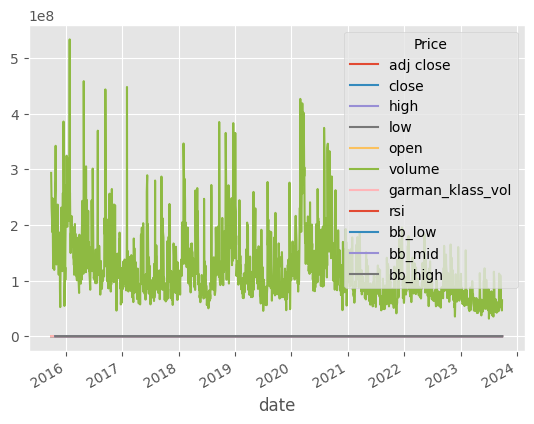

In [ ]:
# Checking Calculation
df.xs('AAPL', level=1).plot()

In [ ]:
# ATR Indicator

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


In [ ]:
# MACD
def compute_macd(close):
  macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

In [ ]:
# Dollar Volume
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


In [ ]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375286   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718922   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145813   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.254013   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001156        NaN       NaN   
           AAPL    293461600.0         -0.005949        NaN       NaN   
           ABBV     12842800.0         -0.059780        NaN       NaN   
           ABT      12287500.0         -0.010671        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000107  26.146731  4.480372   
           YUM       1500600.0         -0.000213  36.057174  4.801976   
           ZBH       3610500.0         -0.000058  31.893254  4.743683   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000032  42.623461  5.151393   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.669694  
           AAPL         NaN       NaN       NaN       NaN    7217.856330  
           ABBV         NaN       NaN       NaN       NaN     458.730967  
           ABT          NaN       NaN       NaN       NaN     407.279177  
           ACGL         NaN       NaN       NaN       NaN      43.853730  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.562291  4.644210  0.033800 -2.159188     116.707107  
           YUM     4.831939  4.861902  0.142547 -1.363696     181.599378  
           ZBH     4.783349  4.823015 -0.381708 -0.881067     401.803403  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.210205  5.269017  0.651515 -1.188278     255.646086  

[982460 rows x 14 columns]

# Aggregate to monthly level and filter top 150 most liquid stocks for each month.
* To reduce training time and experiment with features and strategies, we convert the buisness-daily data to month-end fz.

In [ ]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2015-09-30 A           75.969223
           AAPL      6915.989076
           ABBV       448.332187
           ABT        385.050881
           ACGL        76.237983
...                          ...
2023-09-30 PLTR       651.345225
           ABNB      1633.500725
           CEG        195.997264
           GEHC       212.127119
           KVUE       658.601590

[47363 rows x 1 columns]

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

# df.unstack()[last_cols].resample('M').last().stack().stack('ticker')

In [ ]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()


In [ ]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.525162   38.888981         -0.002190  73.421258   
           AAPL      4014.914542   26.793608         -0.003473  55.537285   
           ABBV       331.841279   39.708744         -0.064880  49.376856   
           ABT        209.554431   37.912804         -0.012576  56.962590   
           ACGL        28.174423   22.970539         -0.001121  35.682522   
...                          ...         ...               ...        ...   
2023-09-30 PLTR       651.345225   13.960000          0.000214  41.544692   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        195.997264  107.492874          0.000035  55.245491   
           GEHC       212.127119   66.083885          0.000184  40.922349   
           KVUE       658.601590   19.642260         -0.000697  35.706330   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.542646  3.615088  3.687529 -1.033887  0.567157  
           AAPL    3.279507  3.322815  3.366124 -0.967900 -0.142790  
           ABBV    3.710011  3.758240  3.806469 -0.526809  0.145677  
           ABT     3.646322  3.668170  3.690018 -1.064842  0.335557  
           ACGL    3.177974  3.195190  3.212406 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.648751  4.688923  4.729095 -0.436215  0.366877  
           GEHC    4.154746  4.212281  4.269817 -0.893478 -1.116462  
           KVUE    2.996823  3.071707  3.146590 -0.899746 -1.435621  

[46388 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.


In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))


In [ ]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)


In [ ]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.153397         -0.002611  49.891102  3.292064   
           ABBV     39.562855         -0.051416  27.477854  3.736752   
           ABT      33.952465         -0.008608  38.008869  3.544925   
           ACN     102.699371         -0.005388  53.823677  4.628986   
           ADBE    107.510002          0.000059  53.668389  4.679513   
...                       ...               ...        ...       ...   
2023-09-30 MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.320942  3.349819 -1.038688 -0.195978  
           ABBV    3.790895  3.845038 -0.893132 -0.760594  
           ABT     3.595386  3.645846 -1.035224 -0.650889  
           ACN     4.640623  4.652259 -0.996806 -0.135457  
           ADBE    4.694639  4.709766 -1.230331 -0.109039  
...                     ...       ...       ...       ...  
2023-09-30 MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           PLTR    2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

# Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.624378         -0.001153  69.196632  3.592536   
           ABBV     66.346977         -0.038051  55.247828  4.179863   
           ABT      48.011189         -0.006128  53.844895  3.882779   
           ACN     128.312408         -0.004612  69.365048  4.794306   
           ADBE    175.160004          0.000067  70.089317  4.951759   
...                       ...               ...        ...       ...   
2023-09-30 MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.639405  3.686275 -0.906642 -0.039276   0.096807   
           ABBV    4.226212  4.272562  0.375557  0.473814   0.022728   
           ABT     3.906344  3.929909 -1.040044  0.276132   0.021276   
           ACN     4.833983  4.873660 -0.986514  0.352341   0.064180   
           ADBE    5.089292  5.226825 -0.888269  0.612102   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           PLTR    2.779743  2.857548 -0.426167 -0.433581  -0.068091   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10353 rows x 14 columns]

# Download Fama-French Factors and Calculate Rolling Factor Betas.

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.096807
           ABBV    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.022728
           ABT     0.0225 -0.0194  0.0019  0.0091 -0.0326   0.021276
           ACN     0.0225 -0.0194  0.0019  0.0091 -0.0326   0.064180
           ADBE    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.009617
           VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056890
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000676
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[10353 rows x 6 columns]

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.096807
           ABBV    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.022728
           ABT     0.0225 -0.0194  0.0019  0.0091 -0.0326   0.021276
           ACN     0.0225 -0.0194  0.0019  0.0091 -0.0326   0.064180
           ADBE    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.009617
           VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056890
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000676
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[10337 rows x 6 columns]

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456337 -0.440101 -0.315507 -0.079740  0.800296
           VZ      0.329036 -0.163596  0.272319  0.320803  0.096977
           WFC     1.112945  0.306861  2.044024 -0.451832 -1.511411
           WMT     0.703224 -0.309991 -0.427582 -0.156628  0.526793
           XOM     0.972448 -1.081440  1.740413 -0.634737 -0.371114

[10337 rows x 5 columns]

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

if('adj close' in data.columns):
    data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10119 entries, (Timestamp('2017-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10119 non-null  float64
 1   rsi               10119 non-null  float64
 2   bb_low            10119 non-null  float64
 3   bb_mid            10119 non-null  float64
 4   bb_high           10119 non-null  float64
 5   atr               10119 non-null  float64
 6   macd              10119 non-null  float64
 7   return_1m         10119 non-null  float64
 8   return_2m         10119 non-null  float64
 9   return_3m         10119 non-null  float64
 10  return_6m         10119 non-null  float64
 11  return_9m         10119 non-null  float64
 12  return_12m        10119 non-null  float64
 13  Mkt-RF            10119 non-null  float64
 14  SMB               10119 non-null  float64
 15  HML      

# For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

## K-Means Clustering


*   You may want to initialize predefined centroids for each cluster based on your research.

*   For visualization purpose of this tutorial we will initially rely on the `k-means++` initialization.


*   Then we will pre-define our centroids for each cluster.



In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def get_cluster(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init=initial_centroids).fit(df).labels_
  return df

data = data.dropna().groupby('date', group_keys=False).apply(get_cluster)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL           -0.001153  69.196632  3.592536  3.639405  3.686275   
           ABBV           -0.038051  55.247828  4.179863  4.226212  4.272562   
           ABT            -0.006128  53.844895  3.882779  3.906344  3.929909   
           ACN            -0.004612  69.365048  4.794306  4.833983  4.873660   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000074  54.722543  3.982183  3.999651  4.017120   
           XOM            -0.000399  59.440212  4.671039  4.711129  4.751219   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906642 -0.039276   0.096807   0.015249   0.044955   
           ABBV    0.375557  0.473814   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276132   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352341   0.064180   0.048454   0.037203   
           ADBE   -0.888269  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400624   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276809 -0.274813   
           ABBV     0.056495   0.047273    0.044026  0.499079  0.359312   
           ABT      0.038672   0.031320    0.029294  0.829185 -0.188547   
           ACN      0.028692   0.027398    0.018728  1.197552 -0.163033   
           ADBE     0.045993   0.049515    0.041515  1.114761 -0.330562   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743593 -0.256720   
           XOM      0.012838   0.008747    0.027037  0.996161 -1.039314   
           MRNA    -0.071952  -0.064976   -0.015431  1.158937  0.746553   
           UBER     0.057244   0.066838    0.043691  1.090266  1.140600   
           CRWD     0.026391   0.047942   -0.002216  0.604910 -0.960057   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.585546  0.639677  0.443301        2  
           ABBV   -0.032821  0.212867  0.172831        3  
           ABT    -0.540948  0.257526  0.978614        3  
           ACN    -0.326806  0.271912  0.164498        2  
           ADBE   -0.170804 -0.218007 -0.696377        2  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.535740 -0.139709  0.661319        1  
           XOM     1.691436 -0.669414 -0.285603        2  
           MRNA   -1.134033  0.610472  0.970465        3  
           UBER   -0.263071 -1.534224 -0.434869        3  
           CRWD   -0.682940 -2.482535 -0.810270        1  

[10119 rows x 19 columns]

In [ ]:
def plot_clusters(data):
  cluster_0 = data[data['cluster']==0]
  cluster_1 = data[data['cluster']==1]
  cluster_2 = data[data['cluster']==2]
  cluster_3 = data[data['cluster']==3]

  plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color='red', label='Cluster 0')
  plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color='green', label='Cluster 1')
  plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color='blue', label='Cluster 2')
  plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color='black', label='Cluster 3')

  plt.legend()
  plt.show()
  return

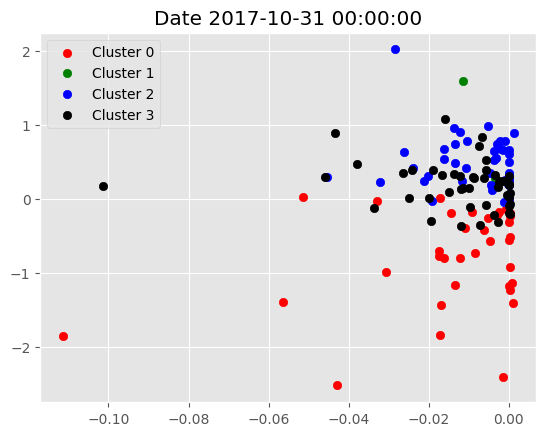

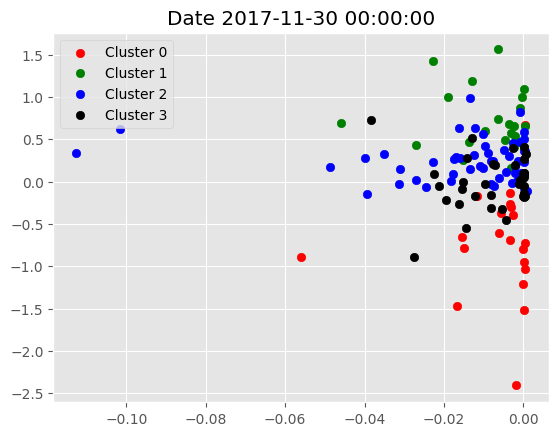

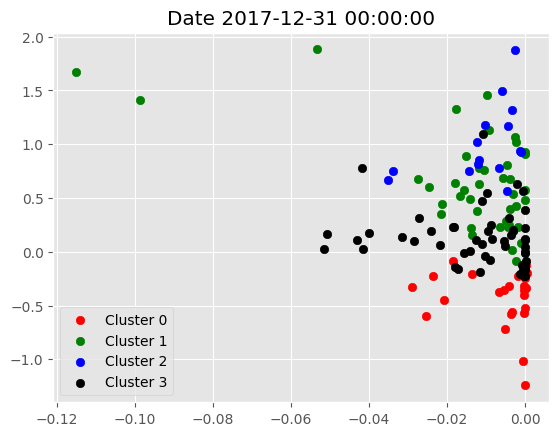

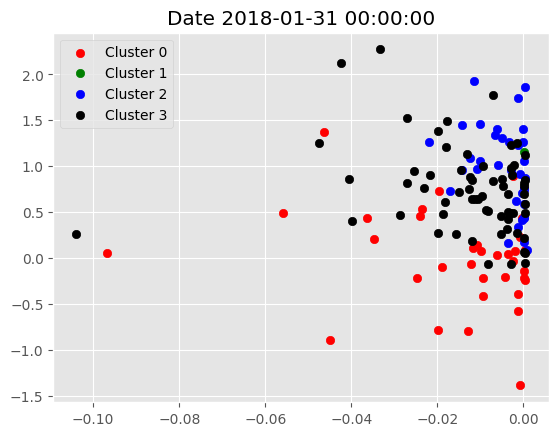

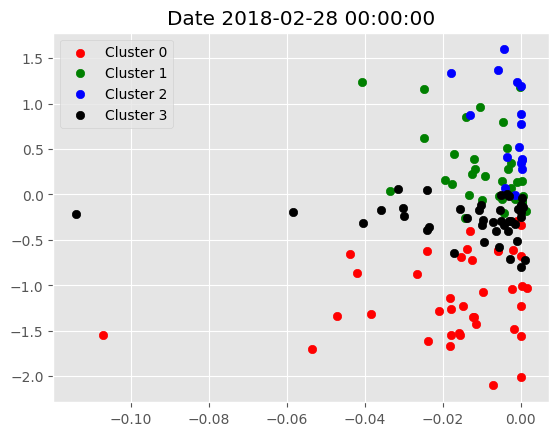

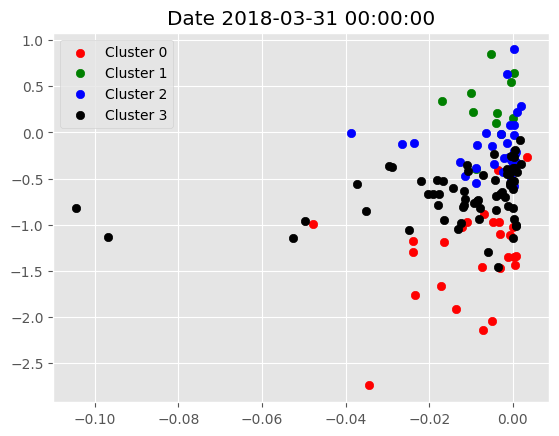

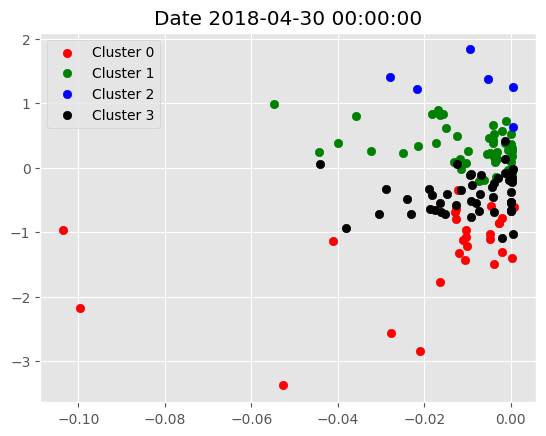

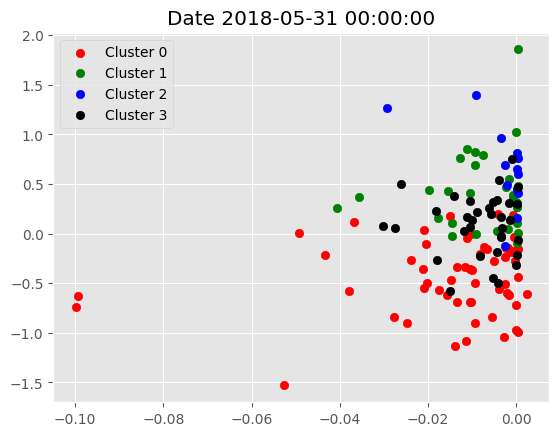

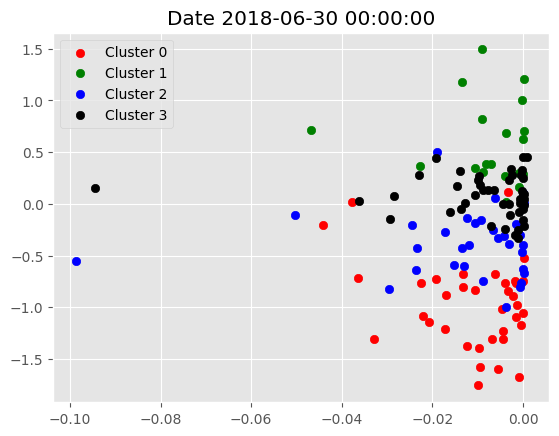

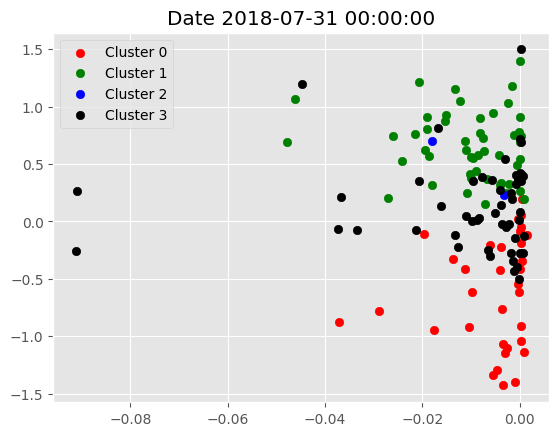

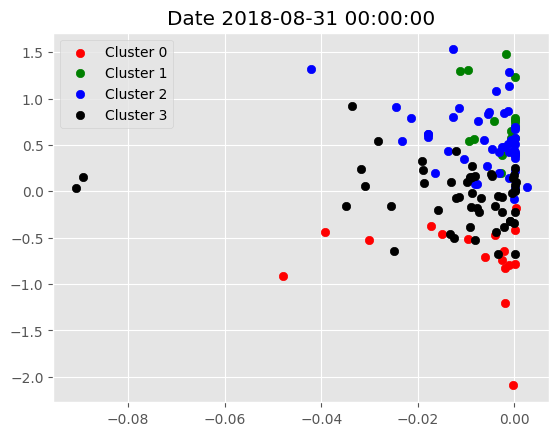

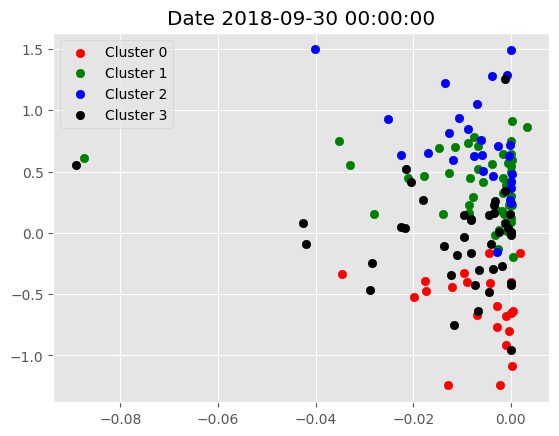

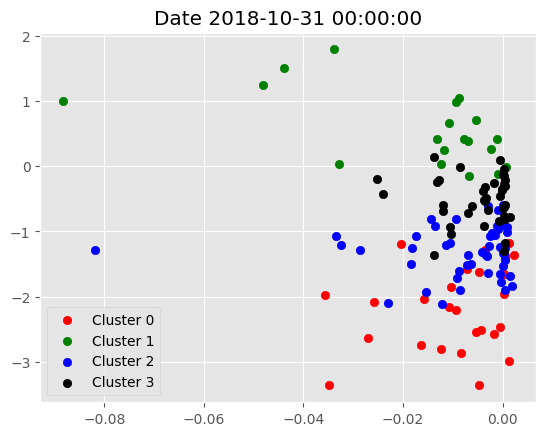

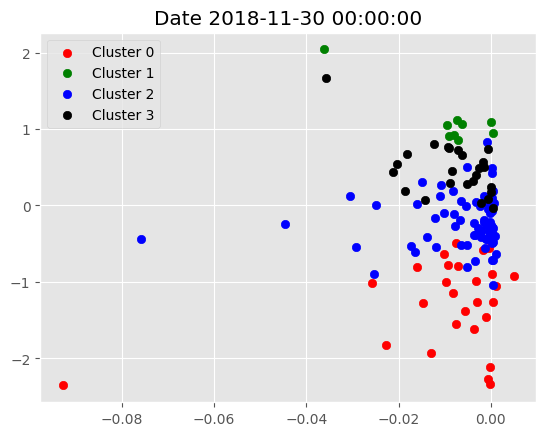

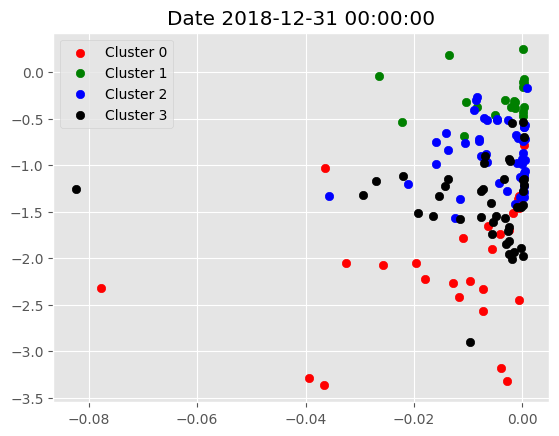

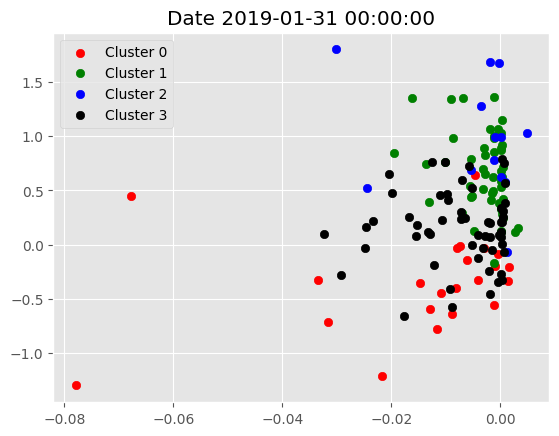

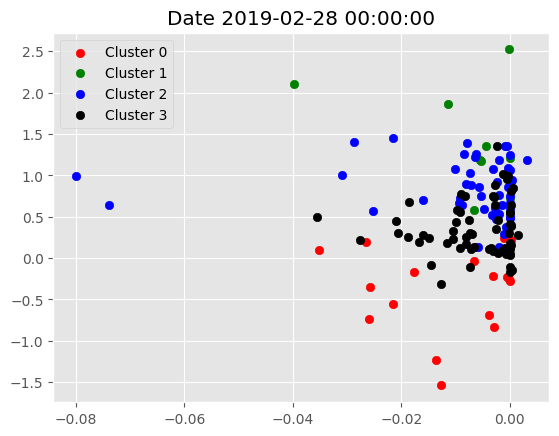

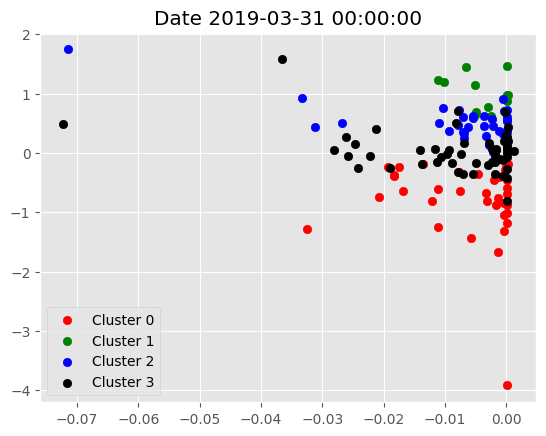

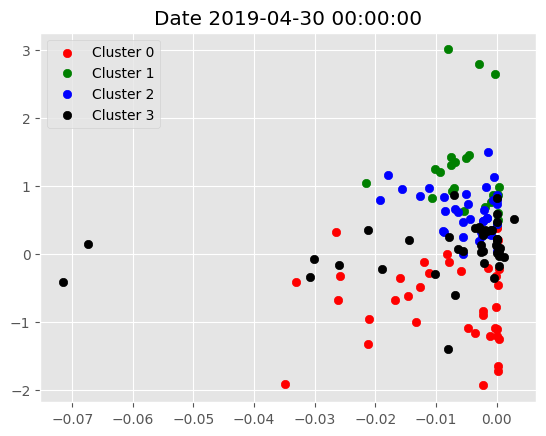

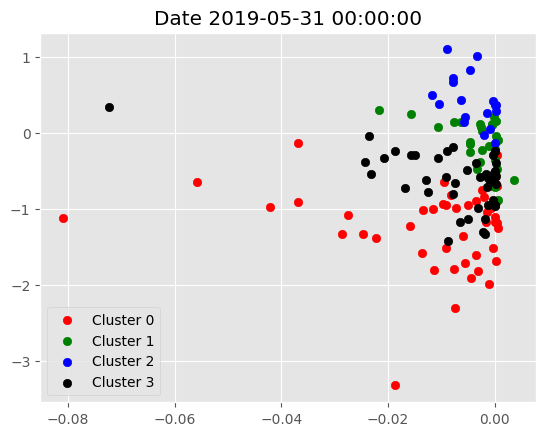

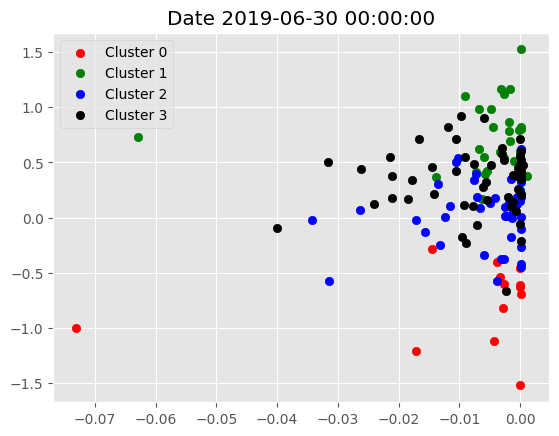

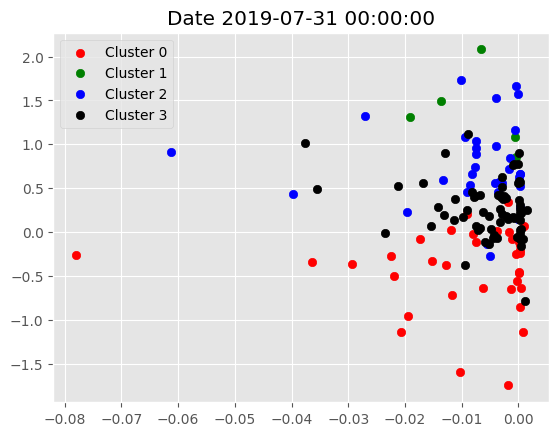

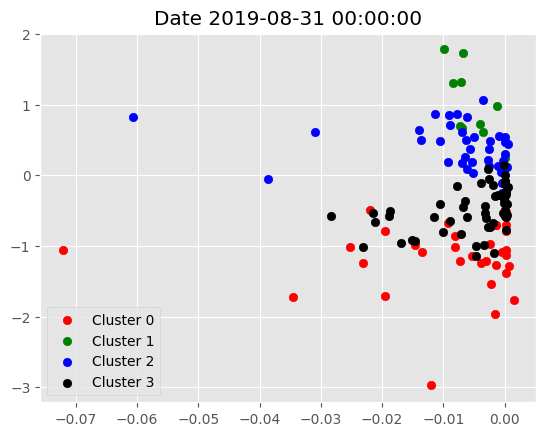

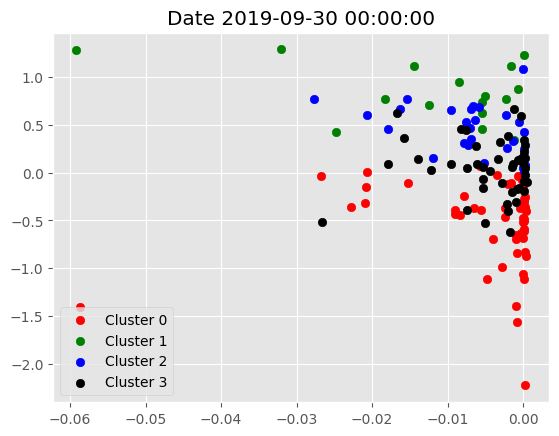

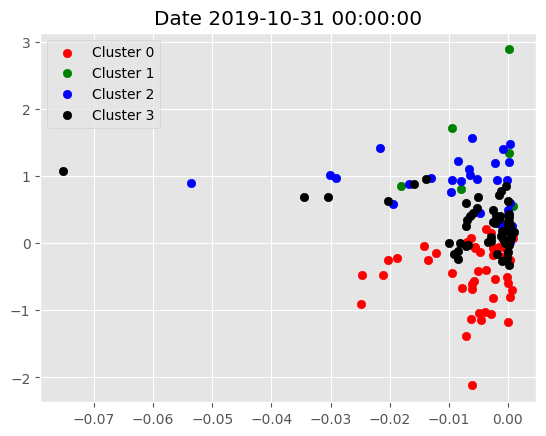

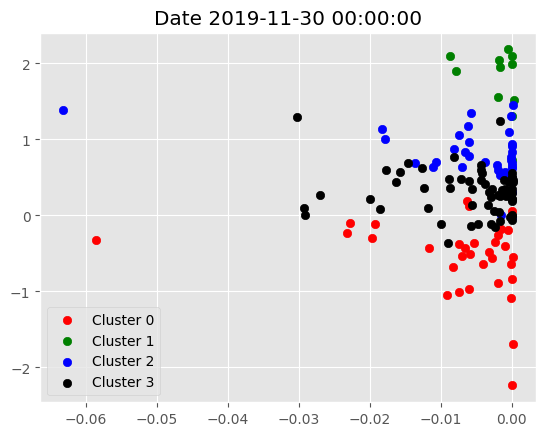

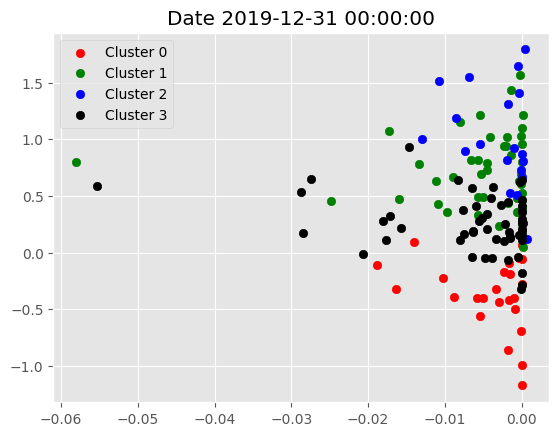

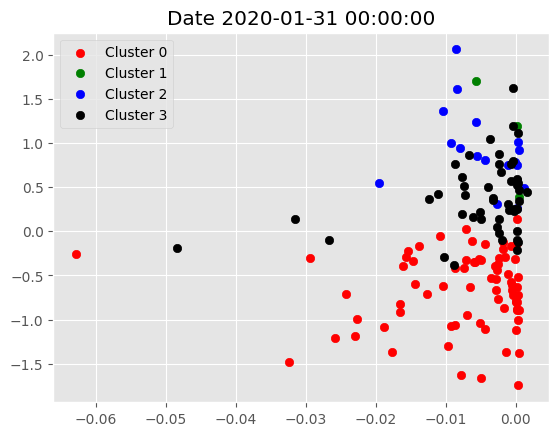

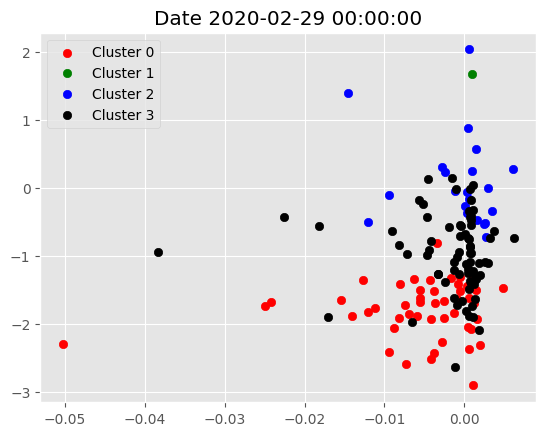

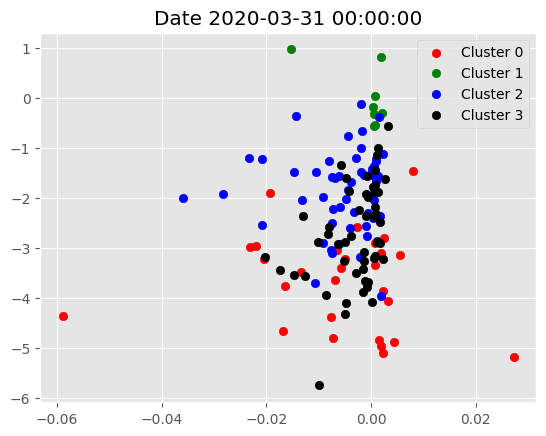

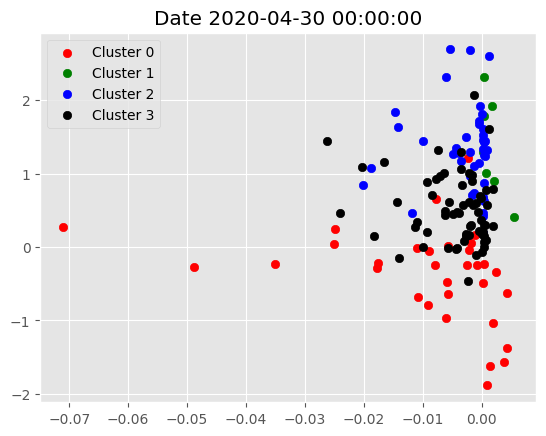

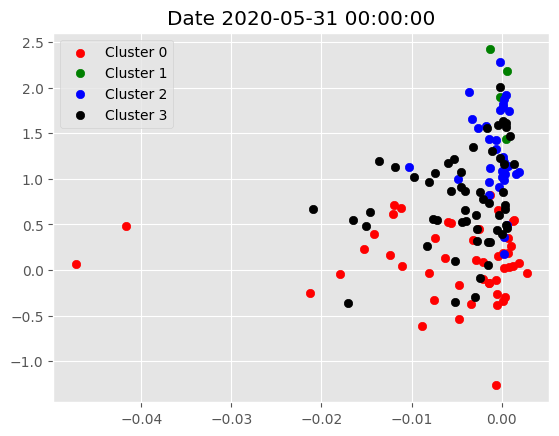

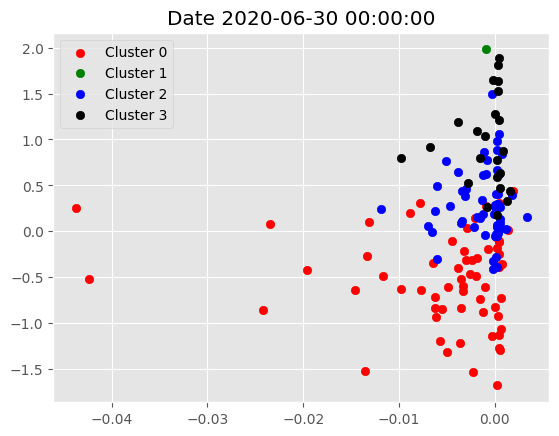

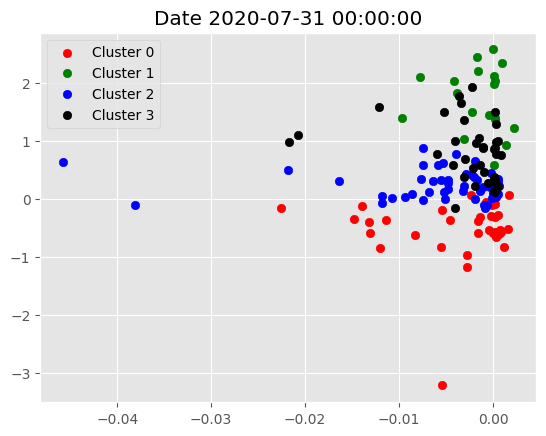

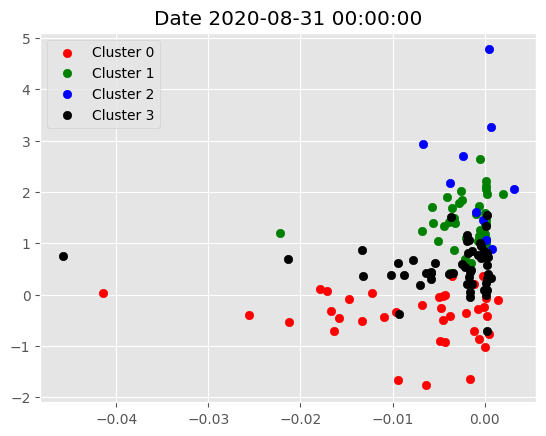

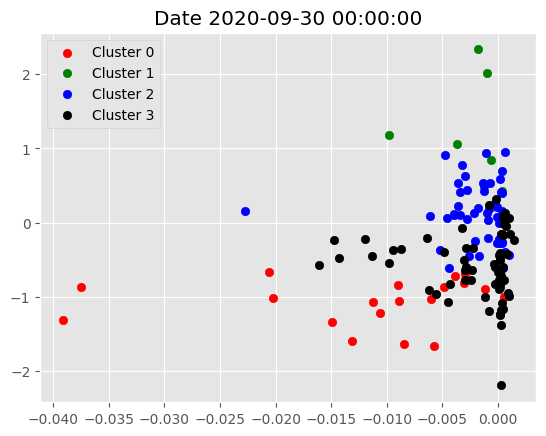

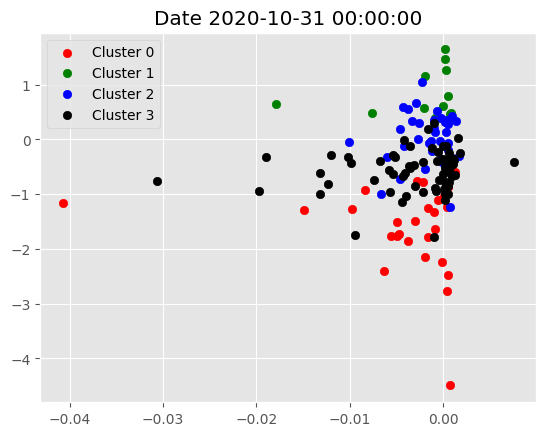

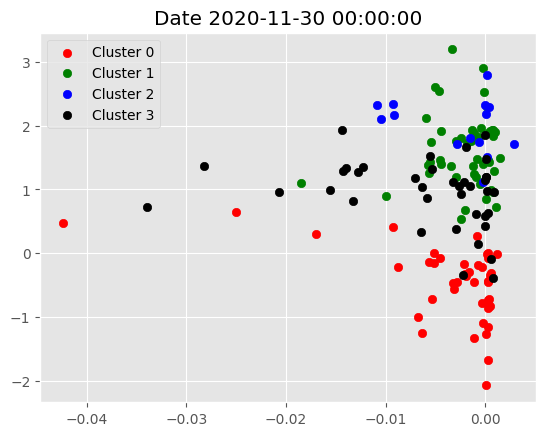

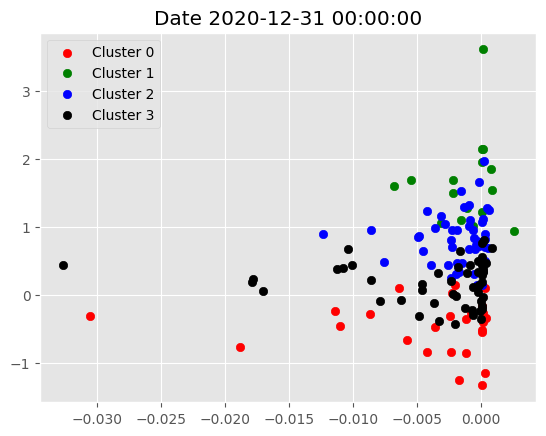

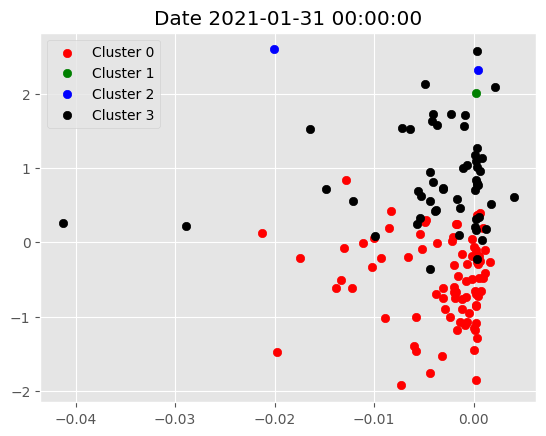

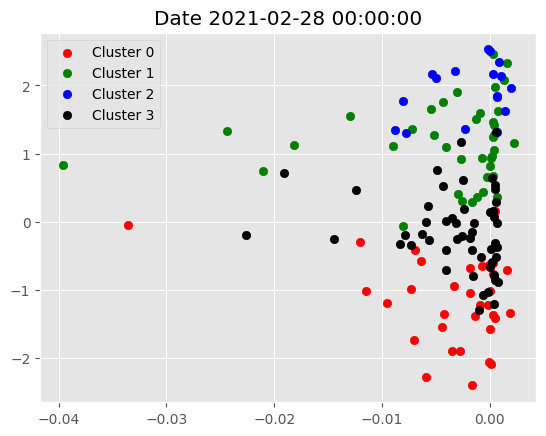

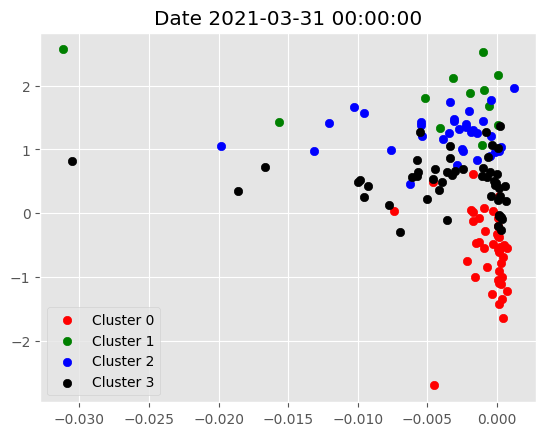

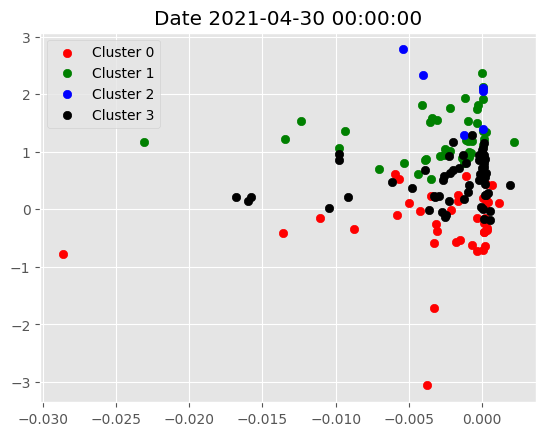

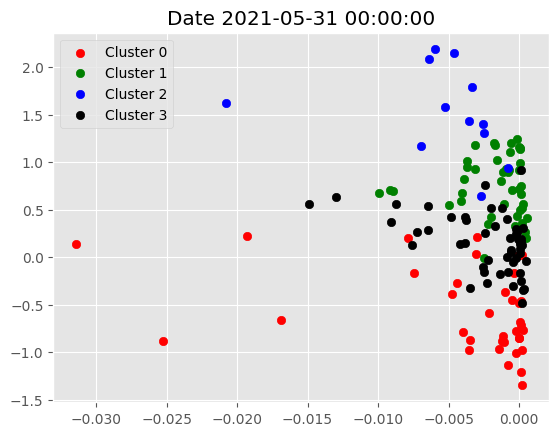

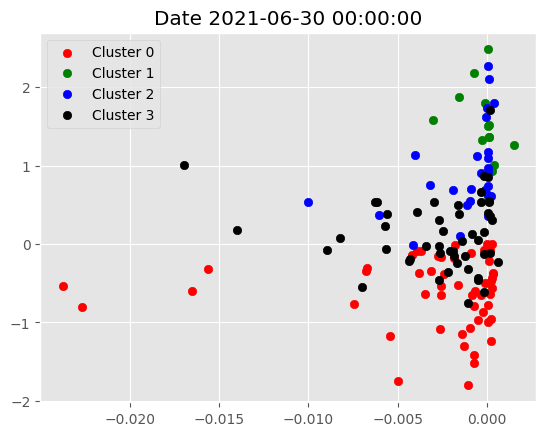

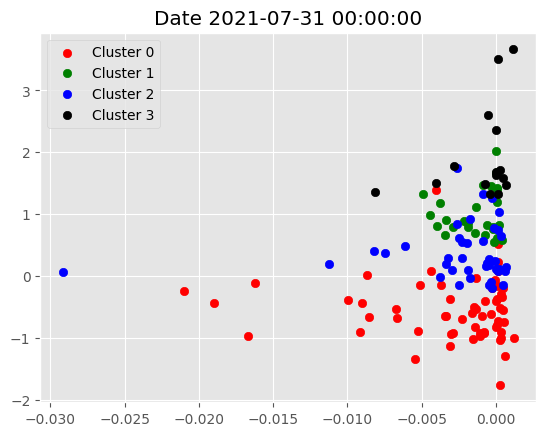

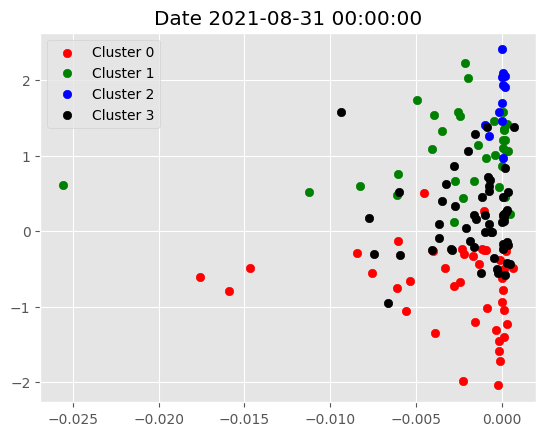

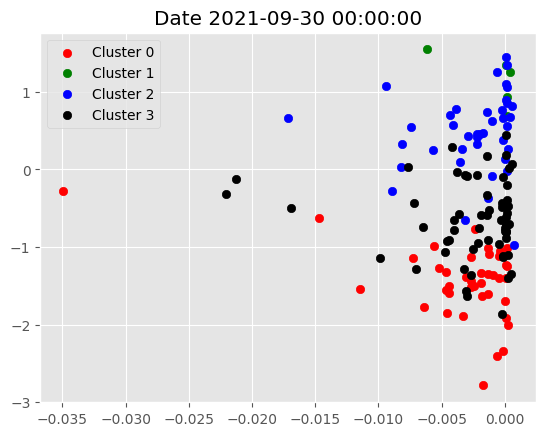

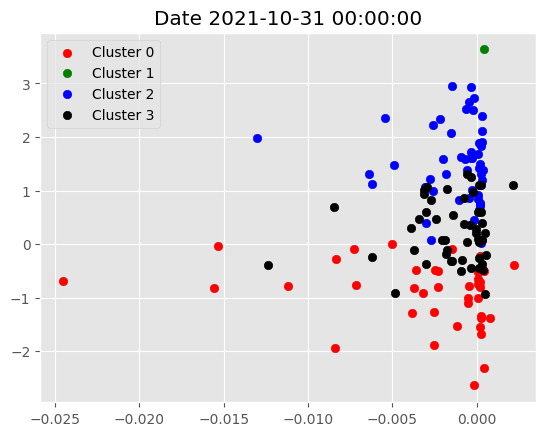

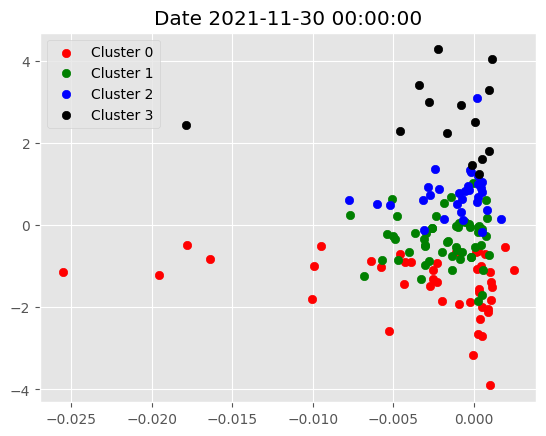

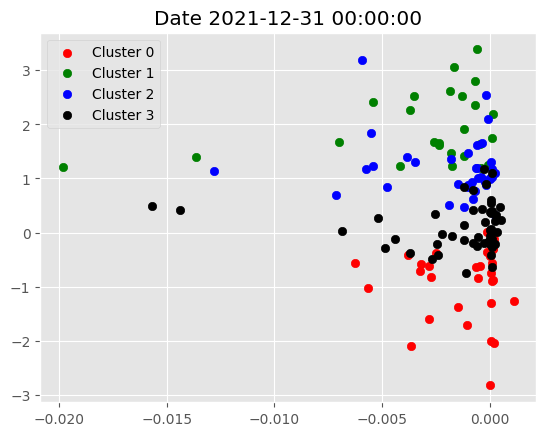

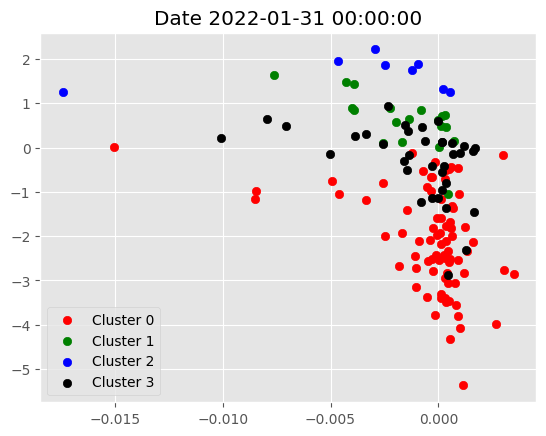

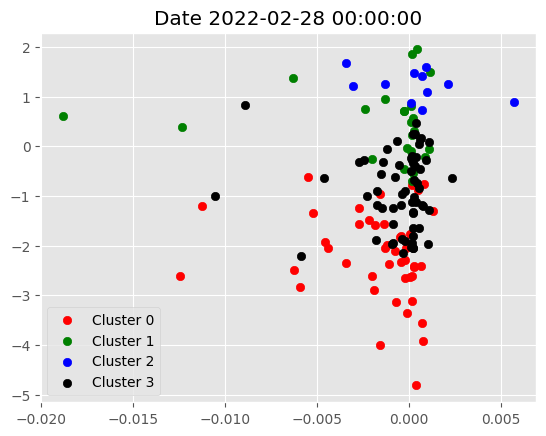

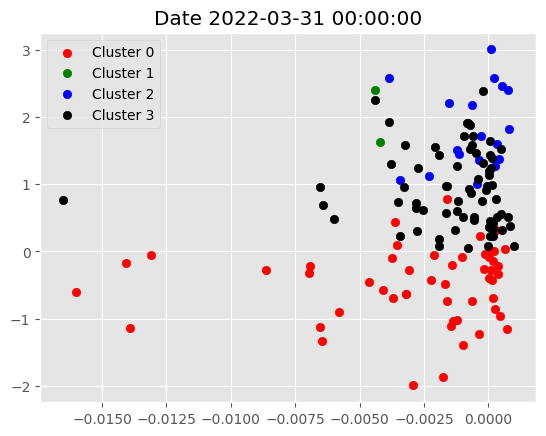

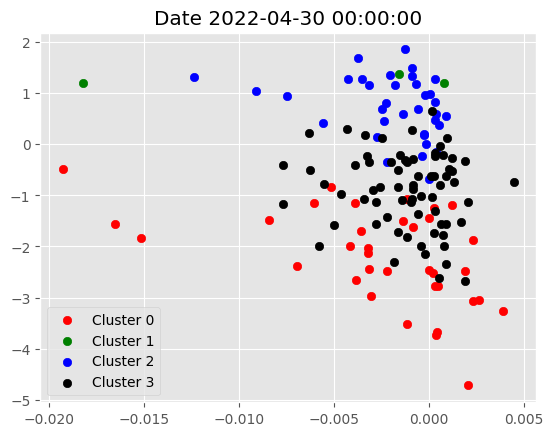

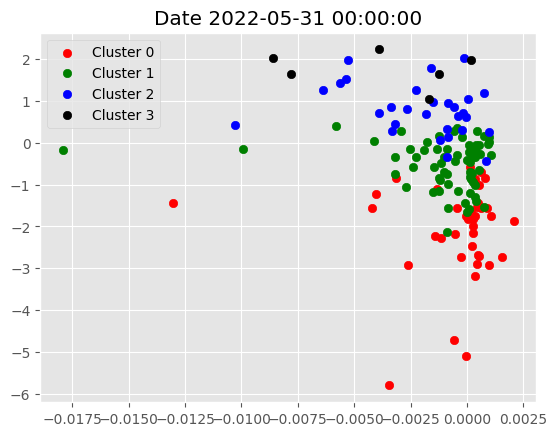

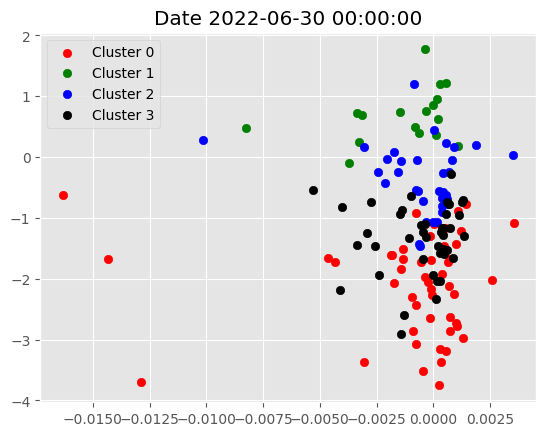

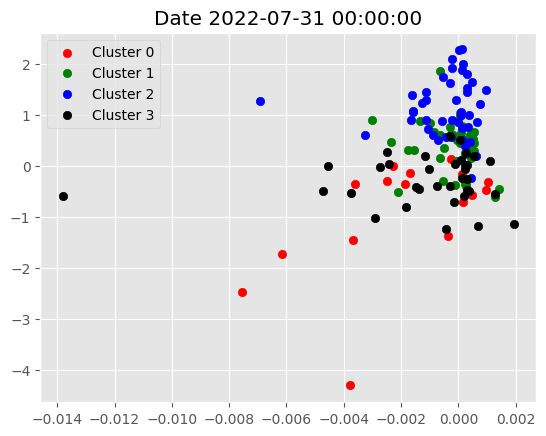

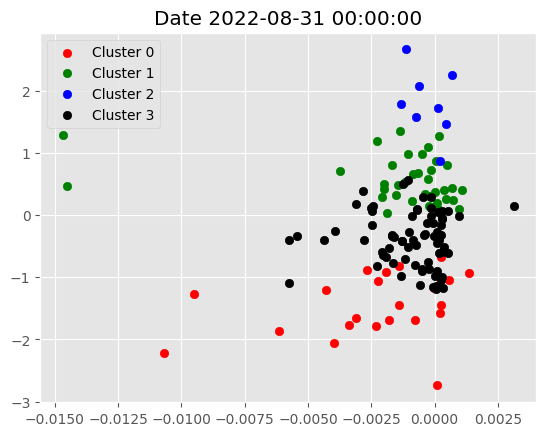

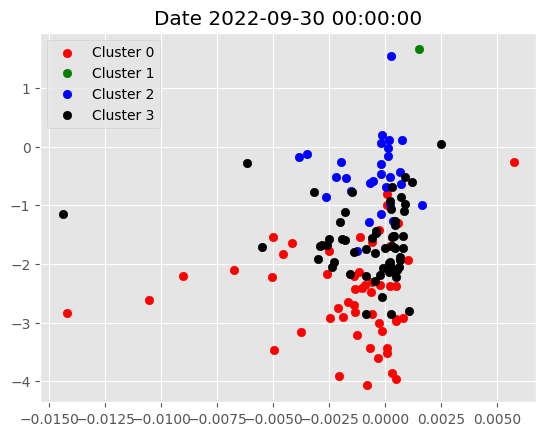

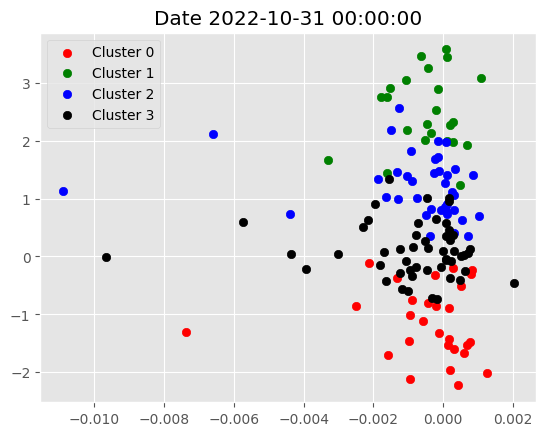

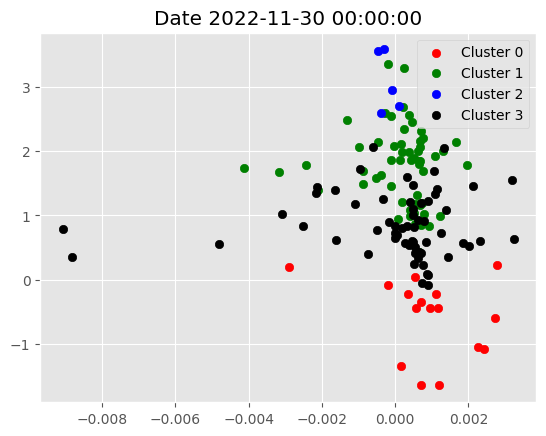

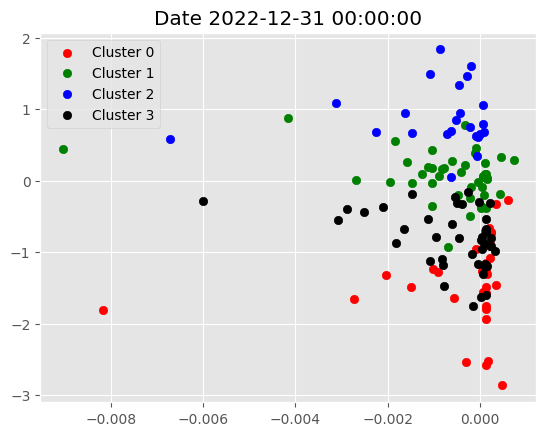

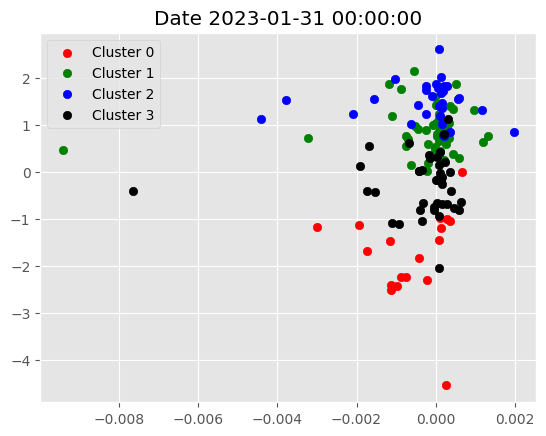

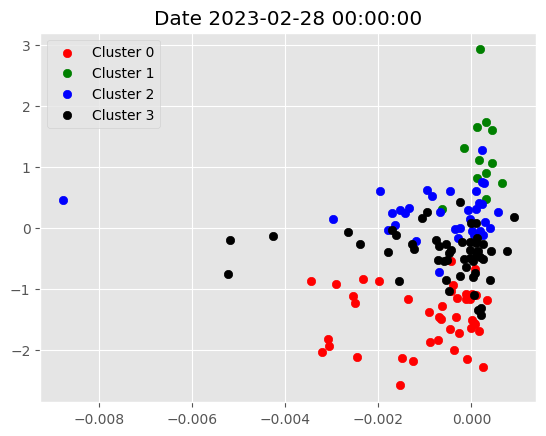

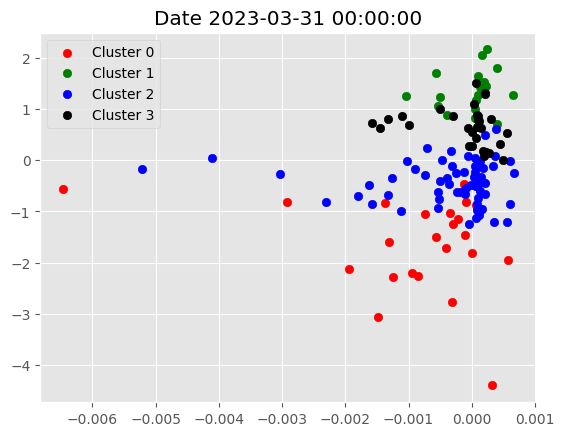

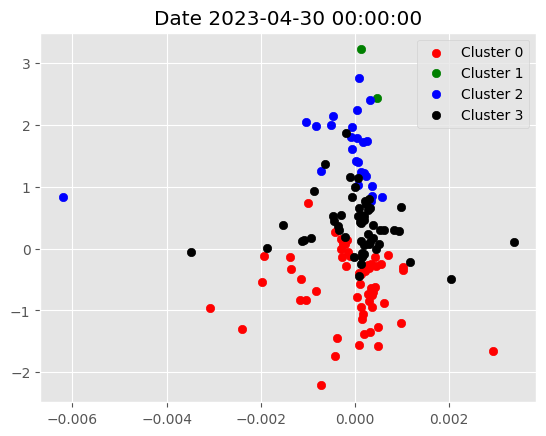

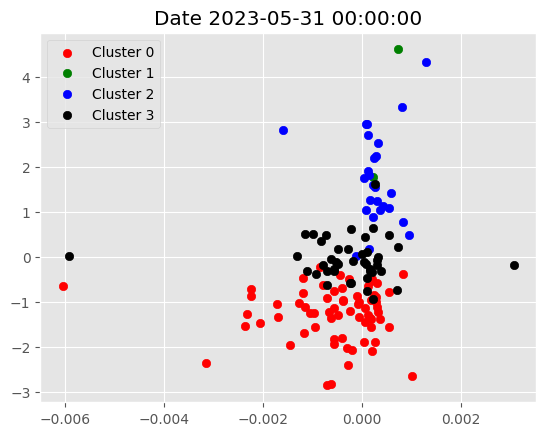

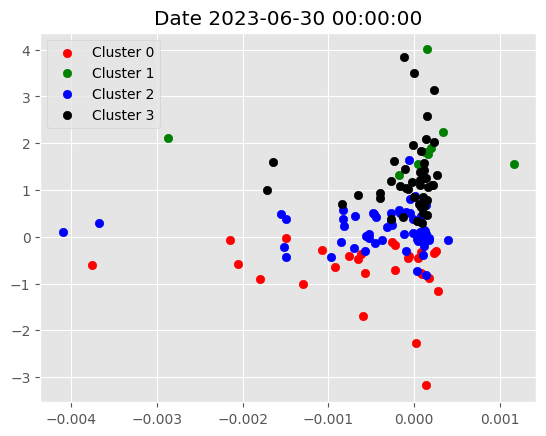

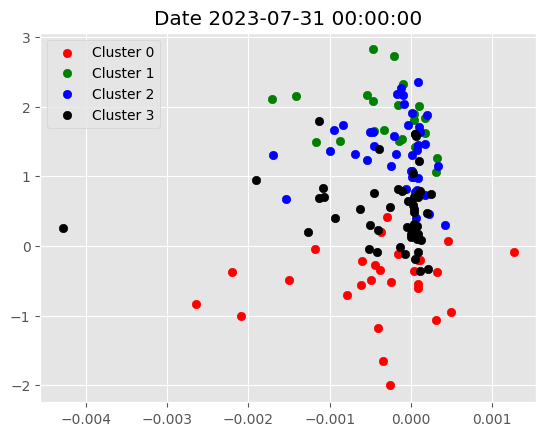

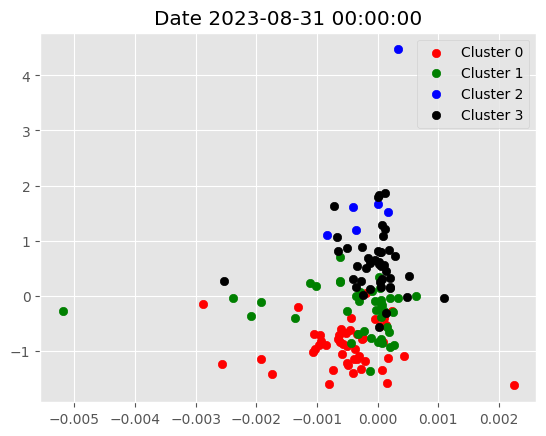

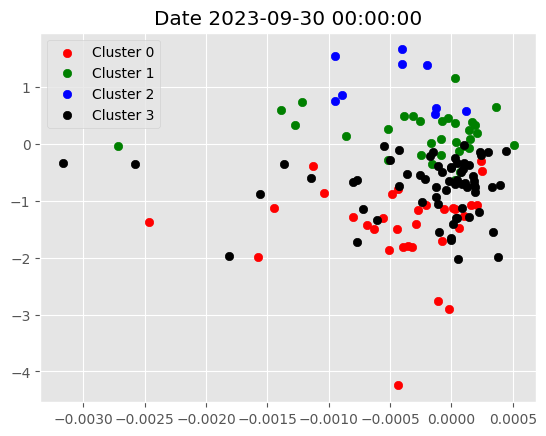

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
  g=data.xs(i,level=0)
  plt.title(f'Date {i}')
  plot_clusters(g)

## Apply Pre-Defined Centroids

In [ ]:
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values
initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

# For each month select assets based on the cluster and form a Portfolio based on Efficient Frontier max sharpe ratio optimization

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-11-01': ['ABBV',
  'ABT',
  'AZO',
  'BA',
  'BKNG',
  'BMY',
  'BRK-B',
  'C',
  'CCL',
  'COST',
  'CSCO',
  'CVX',
  'DD',
  'DG',
  'EA',
  'EBAY',
  'F',
  'FDX',
  'GM',
  'GS',
  'HAL',
  'HD',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
  'KO',
  'LOW',
  'MDLZ',
  'MDT',
  'MO',
  'MS',
  'NFLX',
  'NKE',
  'NOC',
  'ORLY',
  'OXY',
  'PANW',
  'RTX',
  'SBUX',
  'SCHW',
  'TGT',
  'TMO',
  'UNP',
  'UPS',
  'USB',
  'WDC',
  'WYNN'],
 '2017-12-01': ['AAPL',
  'AMGN',
  'BIIB',
  'BMY',
  'CCL',
  'CL',
  'CMCSA',
  'CMG',
  'COP',
  'CRM',
  'DD',
  'EOG',
  'GD',
  'GILD',
  'GM',
  'GOOG',
  'GOOGL',
  'JNJ',
  'KO',
  'LLY',
  'MA',
  'MCK',
  'MDT',
  'META',
  'NVDA',
  'ORCL',
  'PANW',
  'PG',
  'PYPL',
  'STZ',
  'TGT',
  'TMO',
  'TXN',
  'ULTA',
  'V',
  'WBA'],
 '2018-01-01': ['ABBV',
  'ADBE',
  'AMZN',
  'BIIB',
  'C',
  'CCL',
  'CHTR',
  'CMCSA',
  'CSX',
  'CVS',
  'DD',
  'DHR',
  'DIS',
  'EBAY',
  'ELV',
  'F',
  'GD',
  'GOOG',
  'GOOGL',
  'GS',
  'HON',
 

# Define Portfolio Optimization Function

In [ ]:
!pip install PyPortfolioOpt


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

* Download Fresh Daily Prices Data only for short listed stocks

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  155 of 155 completed


Price        Adj Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2016-10-31   26.153395   39.562859  33.952461  102.699379  107.510002   
2016-11-01   25.681187   40.038074  33.788059  102.611023  106.870003   
2016-11-02   25.704222   40.279205  33.485229  104.793304  105.889999   
2016-11-03   25.428703   39.640877  33.208347  103.326675  107.169998   
2016-11-04   25.199493   39.747269  33.822678  103.574059  106.199997   
...                ...         ...        ...         ...         ...   
2023-09-25  174.991043  147.717545  95.036850  310.686249  511.600006   
2023-09-26  170.896515  147.010712  93.827797  304.433167  506.299988   
2023-09-27  169.375961  146.265671  93.145271  308.128174  502.600006   
2023-09-28  169.634369  145.425125  95.670616  294.788849  504.670013   
2023-09-29  170.151154  142.378113  94.432320  301.002777  509.899994   

Price                                                                  ...  \
Ticker             ADP        ADSK        AIG        AMAT         AMD  ...   
Date                                                                   ...   
2016-10-31   73.460251   72.279999  50.185955   26.493134    7.230000  ...   
2016-11-01   73.342117   70.099998  49.356300   26.329140    7.090000  ...   
2016-11-02   75.924110   68.680000  49.250568   26.046715    6.760000  ...   
2016-11-03   75.375656   67.610001  47.298439   25.755184    6.700000  ...   
2016-11-04   75.164703   69.440002  46.672123   25.709639    6.560000  ...   
...                ...         ...        ...         ...         ...  ...   
2023-09-25  234.658096  205.669998  60.836143  135.241089   97.379997  ...   
2023-09-26  231.940216  201.660004  59.984261  132.755875   95.959999  ...   
2023-09-27  237.209793  202.279999  59.739460  133.726196   98.070000  ...   
2023-09-28  237.874588  207.889999  60.003845  136.855011  102.760002  ...   
2023-09-29  235.205597  206.910004  59.338001  137.082733  102.820000  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 930 columns]

* Calculate daily returns for each stock which could land up in our portfolio.
* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.
* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.
* Calculated each day portfolio return

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in

""


#  Visualize Portfolio returns and compare to SP500 returns.

In [116]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [115]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

TypeError: cannot do slice indexing on RangeIndex with these indexers [2023-09-29] of type str